In [33]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt

stdout = sys.stdout

#sales_train = pd.read_csv("/Users/djmore/Udacity/machine-learning/projects/capstone/sales_train.csv", sep =',', skiprows=[1,220000], nrows = 100000)

sales_train     = pd.read_csv("/Users/djmore/Udacity/machine-learning/projects/capstone/sales_train.csv", sep =',')
items           = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/items.csv')
item_categories = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/item_categories.csv')
shops           = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/shops.csv')
test            = pd.read_csv('/Users/djmore/Udacity/machine-learning/projects/capstone/test.csv')

sales_data           = pd.DataFrame(sales_train)
items_data           = pd.DataFrame(items)
item_categories_data = pd.DataFrame(item_categories)
shops_data           = pd.DataFrame(shops)
kaggle_data          = pd.DataFrame(test)

In [34]:
display(sales_data.isnull().any())

print('Shops               - {}'.format(shops_data['shop_id'].count()))
print('Item Categories     - {}'.format(items_data['item_category_id'].nunique()))
print('Items               - {}'.format(items_data['item_id'].count()))
print('Median item price   - {}'.format(sales_data['item_price'].median()))
print('Min item price      - {}'.format(sales_data['item_price'].min()))
print('Max item price      - {}'.format(sales_data['item_price'].max()))
print('Total Rows          - {}'.format(sales_data['shop_id'].count()))
print('')

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

Shops               - 60
Item Categories     - 84
Items               - 22170
Median item price   - 399.0
Min item price      - -1.0
Max item price      - 307980.0
Total Rows          - 2935849



In [35]:
# Convert date field to datetime field in pandas
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Extract out date features
sales_data['year']  = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
sales_data['day']   = sales_data['date'].dt.day

# Sort data in ascending order of time series - year, month,and day
sales_data.sort_values(['date_block_num','date'], ascending=[True,True],inplace=True)

In [36]:
# Since we have to predict monthly sales numbers
# we will aggregate the daily sales data to monthly.

monthly_sales=pd.DataFrame(sales_data.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum().reset_index())
monthly_item_price = pd.DataFrame(sales_data.groupby(["shop_id","item_id","date_block_num"])["item_price"].mean().reset_index())
monthly_sales = pd.merge(monthly_sales,monthly_item_price[["shop_id","item_id","date_block_num","item_price"]], on=["shop_id","item_id","date_block_num"], how='inner')
# Sort data in place
# This is required so we can take the last couple months of data for validation and testing.

monthly_sales.sort_values(['date_block_num','shop_id','item_id','item_price'],inplace=True, ascending=[True,True,True,True])


In [37]:
display(monthly_sales.tail(5))

,shop_id,item_id,date_block_num,item_cnt_day,item_price
1608998,59,22087,33,6.0,119.0
1609030,59,22088,33,2.0,119.0
1609047,59,22091,33,1.0,179.0
1609073,59,22100,33,1.0,629.0
1609076,59,22102,33,1.0,1250.0


## Generate lag features
## We generate total sales for each shop_id, item_id pair across 34 months.

In [38]:
monthly_lag_features = pd.DataFrame(pd.pivot_table(monthly_sales, values='item_cnt_day', index=['shop_id','item_id','item_price'], aggfunc=[np.sum], columns = ['date_block_num'],fill_value=0).reset_index())

In [39]:
display(monthly_lag_features.tail(5))

shop_id item_id item_price sum                   ...           \
date_block_num                              0  1  2  3  4  5  6 ... 24 25 26   
720741              59   22162      349.0   0  0  0  0  0  0  0 ...  0  0  0   
720742              59   22162      399.0   0  0  0  0  0  0  0 ...  0  9  4   
720743              59   22164      699.0   0  0  0  0  0  0  0 ...  0  0  0   
720744              59   22164      749.0   0  0  0  0  0  0  0 ...  0  2  1   
720745              59   22167      299.0   0  0  0  0  0  0  0 ...  0  0  0   

                                     
date_block_num 27 28 29 30 31 32 33  
720741          1  1  0  0  1  0  0  
720742          0  0  0  0  0  0  0  
720743          2  0  0  1  0  0  0  
720744          0  0  0  0  0  0  0  
720745          0  0  0  0  0  0  0  

[5 rows x 37 columns]

In [2]:
# Save the above pivot table as CSV/Excel
monthly_lag_features.to_csv('monthly_pivot_sales.csv')

In [40]:
## Update the csv file in excel to remove pivot levels and aggregate headers
monthly_pivot_sales_table = pd.read_csv('monthly_pivot_sales.csv')
monthly_sales_table       = pd.DataFrame(monthly_pivot_sales_table)

In [41]:
monthly_sales_lag_features = pd.merge(monthly_sales,monthly_sales_table[['shop_id','item_id','item_price','0','1','2','3','4','5','6','7','8','9','10',\
                                                                         '11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27',\
                                                                        '28','29','30','31','32','33']], on=['shop_id','item_id','item_price'], how='inner')

In [42]:
monthly_sales_lag_features.sort_values(['date_block_num','shop_id','item_id'],inplace=True,ascending=[True,True,True])

In [43]:
monthly_sales_lag_features.head(5)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,0,1,2,3,4,...,24,25,26,27,28,29,30,31,32,33
0,0,32,0,6.0,221.0,6,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,33,0,3.0,347.0,3,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,0,1.0,247.0,1,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,43,0,1.0,221.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,51,0,2.0,128.5,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
## Keep only lag features - previous month's item_count sales for each shop and for each item in a given month
## Remove current month and future month (date_block_num) corresponding count from lag features
for i in range(0,34):
    for j in range(i,34):
        monthly_sales_lag_features.loc[(monthly_sales_lag_features['date_block_num']==i),str(j)] = 0

In [45]:
monthly_sales_lag_features.tail(5)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,0,1,2,3,4,...,24,25,26,27,28,29,30,31,32,33
1401647,59,22087,33,6.0,119.0,0,0,0,0,0,...,0,10,5,2,2,1,5,2,3,0
1401656,59,22088,33,2.0,119.0,0,0,0,0,0,...,0,3,4,3,3,4,7,7,1,0
1559819,59,22091,33,1.0,179.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
1559821,59,22100,33,1.0,629.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1505746,59,22102,33,1.0,1250.0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0


In [46]:
monthly_sales_lag_features['shop_id']=pd.Categorical(monthly_sales_lag_features['shop_id'])
monthly_sales_lag_features['item_id']=pd.Categorical(monthly_sales_lag_features['item_id'])

## Prepare Train-Validation-Test Data Split

In [47]:
X_train = monthly_sales_lag_features[monthly_sales_lag_features.date_block_num < 29]
y_train = X_train['item_cnt_day']
del X_train['item_cnt_day']

X_val = monthly_sales_lag_features[(monthly_sales_lag_features.date_block_num >=29) & (monthly_sales_lag_features.date_block_num <=32)] 
y_val = X_val['item_cnt_day']
del X_val['item_cnt_day']

X_test = monthly_sales_lag_features[monthly_sales_lag_features.date_block_num == 33]
y_test = X_test['item_cnt_day']
del X_test['item_cnt_day']

## Simple Deep Neural Model
##

In [248]:

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization

# define the model
model = Sequential()
#model.add(Dense(100, input_shape=X_train.shape[1:],activation=None, kernel_initializer='he_normal'))
model.add(Dense(100, input_shape=X_train.shape[1:],activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Dropout(0.02))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
#model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Dropout(0.02))
model.add(Dense(1, activation=None))

# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 100)               3900      
_________________________________________________________________
batch_normalization_33 (Batc (None, 100)               400       
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 50)                5050      
_________________________________________________________________
batch_normalization_34 (Batc (None, 50)                200       
_________________________________________________________________
dropout_36 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 51        
Total para

In [249]:
from keras import metrics
from keras.optimizers import Adam

opt = RMSprop(lr=0.002)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

In [250]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='predict_monthly_sales.model.best.lag.features_5th_run.hdf5', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=10000, epochs=25, validation_data=(X_val, y_val), 
                 callbacks=[checkpointer],verbose=1)

Train on 1416891 samples, validate on 125554 samples
Epoch 1/25
1416891/1416891 [==============================] - 37s 26us/step - loss: 33.0685 - mean_absolute_error: 1.4459 - val_loss: 15.7485 - val_mean_absolute_error: 1.2719

Epoch 00001: val_loss improved from inf to 15.74846, saving model to predict_monthly_sales.model.best.lag.features_5th_run.hdf5
Epoch 2/25
1416891/1416891 [==============================] - 33s 23us/step - loss: 28.5354 - mean_absolute_error: 1.4048 - val_loss: 11.5793 - val_mean_absolute_error: 0.9667

Epoch 00002: val_loss improved from 15.74846 to 11.57933, saving model to predict_monthly_sales.model.best.lag.features_5th_run.hdf5
Epoch 3/25
1416891/1416891 [==============================] - 31s 22us/step - loss: 26.8044 - mean_absolute_error: 1.3958 - val_loss: 11.6070 - val_mean_absolute_error: 1.3093

Epoch 00003: val_loss did not improve from 11.57933
Epoch 4/25
1416891/1416891 [==============================] - 32s 22us/step - loss: 25.9252 - mean_abso

/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


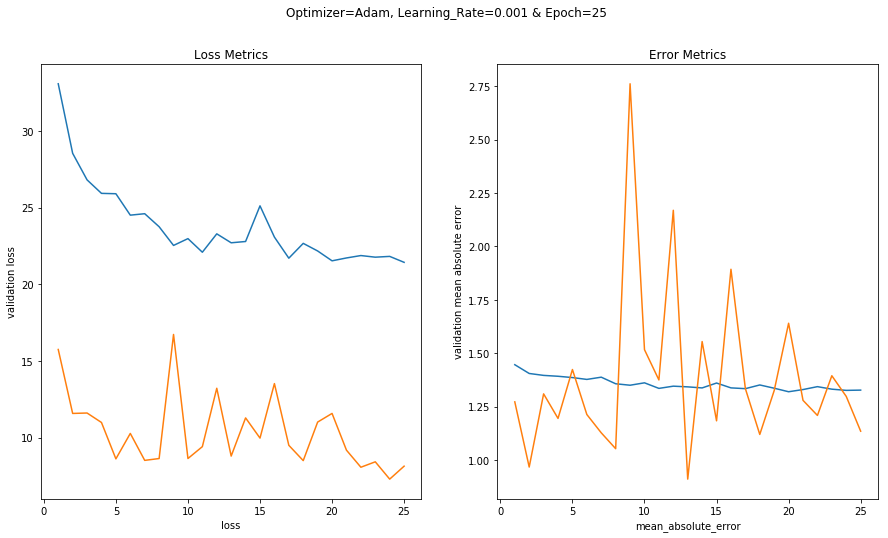

In [251]:
# Plot model performance 
fig = plt.figure(figsize = (15,8))
fig.suptitle('Optimizer=Adam, Learning_Rate=0.001 & Epoch=25')
ax = fig.add_subplot(1,2,1)
x = np.array(range(1, len(hist.history['loss'])+1))
y = np.transpose([hist.history[k] for k in ['loss', 'val_loss']])
#ax.set_ylim((0.0, 3.0))
ax.plot(x, y)
ax.set(xlabel='loss', ylabel='validation loss')
ax.set_title('Loss Metrics')


# Plot model performance 
#fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,2,2)
x = np.array(range(1, len(hist.history['loss'])+1))
y = np.transpose([hist.history[k] for k in ['mean_absolute_error', 'val_mean_absolute_error']])
#ax.set_ylim((0.0, 3.0))
ax.set(xlabel='mean_absolute_error',ylabel='validation mean absolute error')
ax.set_title('Error Metrics')
ax.plot(x, y)
fig.show()

In [149]:
print(hist)

In [242]:
# evaluate test accuracy

[rmse,mae] = model.evaluate(X_test, y_test, verbose=0)

print(rmse,mae)

29.550697400815082 1.4081285575616524


In [243]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = model.predict(X_test)

meanSquaredError=mean_squared_error(y_test, y_pred)
print("MSE:", meanSquaredError)

rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 29.550696694728593
RMSE: 5.4360552512579


In [244]:
y_pred=y_pred.reshape((-1,))
print(y_pred.shape,y_test.shape)

(31129,) (31129,)


In [245]:
print("Total sales across all shops during October 2015 is {}".format(y_test.sum()))
print("Deep neural network model predicted {} ".format(round(y_pred.sum())))
print("Mean Absolute Error of {} ".format((np.mean(abs(y_pred-y_test)))))

Total sales across all shops during October 2015 is 62827.0
Deep neural network model predicted 62950.0 
Mean Absolute Error of 1.4081285549824671 


### Visualization

/Users/djmore/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


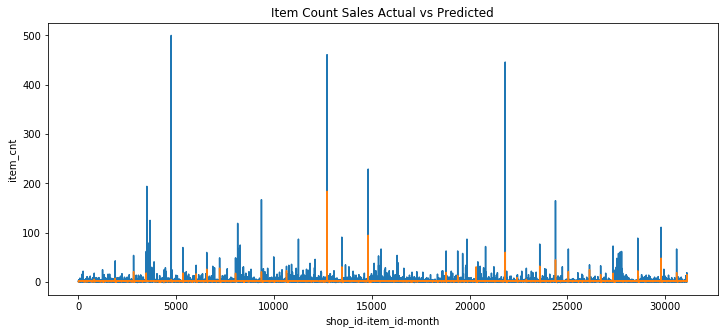

In [247]:
from matplotlib import pyplot as plt

# Plot model performance on test set 
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(111)
x = np.array(range(1, len(y_test)+1))
y = np.transpose([y_test,y_pred])
#ax.set_ylim((0.0, 2500.0))
ax.set(xlabel='shop_id-item_id-month',ylabel='item_cnt')
ax.set_title('Item Count Sales Actual vs Predicted')
ax.plot(x, y)
fig.show()